# Determining $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ flux selected of DESIJ1018-0121

**Author(s)**: Muhammad Jobair Hasan, Sulyman Hossain, Anowar Shajib \
**Acknowledgement(s)**: S M Rafee Adnan, Ahmad Al-Imtiaz

## Import libraries and load data

In [1]:
!pip install photutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.cosmology import FlatLambdaCDM
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [3]:
data, header = fits.getdata(
    "/kaggle/input/fits-file/DESIJ1018-0121_F140W_drz_sci.fits", header=True
)

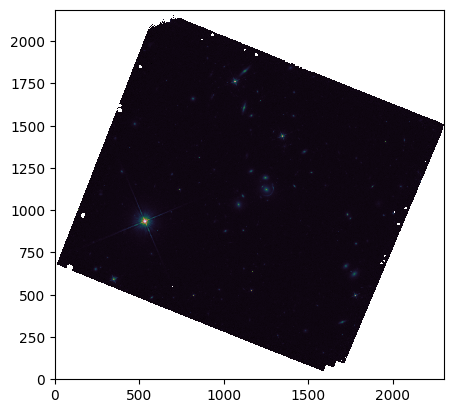

In [4]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [5]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

/tmp/ipykernel_18/1236197877.py:2: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background),
/tmp/ipykernel_18/1236197877.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


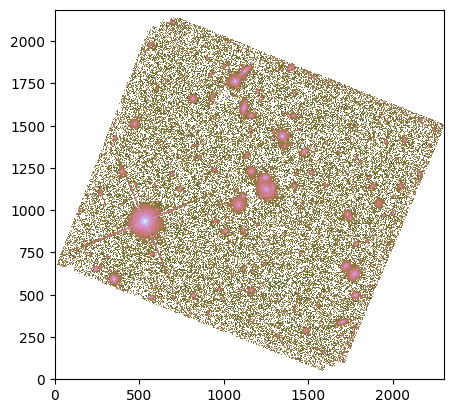

In [6]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [7]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.55643857, 0.018628549)

In [8]:
bkg_subtracted_data = data - bkg.background

In [9]:
threshold = 4 * bkg.background_rms

In [10]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [11]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [12]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2187, 2305)
nlabels: 583
labels: [  1   2   3   4   5 ... 579 580 581 582 583]


In [13]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 583
labels: [  1   2   3   4   5 ... 579 580 581 582 583]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region surrounding your lensing system

In [14]:
set_x_lim1, set_x_lim2 = 1257 - 700, 1257 + 700
set_y_lim1, set_y_lim2 = 1127 - 700, 1127 + 700

/tmp/ipykernel_18/1437010873.py:5: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/1437010873.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


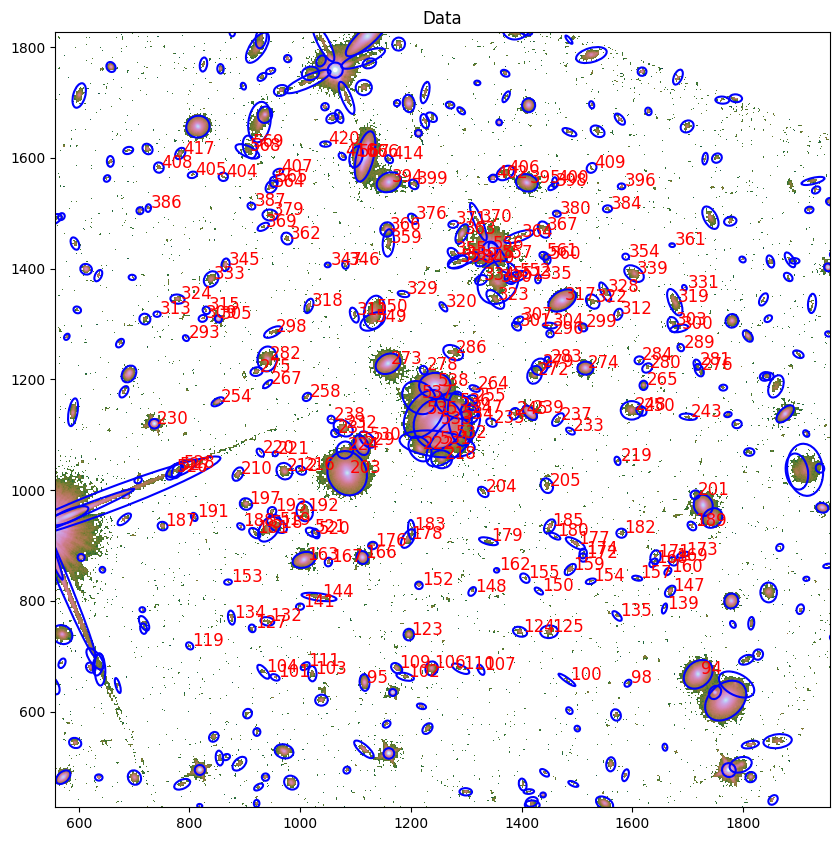

In [15]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[535]) < 500
        and np.abs(cat.ycentroid[i] - cat.ycentroid[535]) < 500
    ):
        ax1.text(
            cat.xcentroid[i] + 5,
            cat.ycentroid[i],
            f"{i}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )

# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## The central deflector

/tmp/ipykernel_18/3888502924.py:8: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/3888502924.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


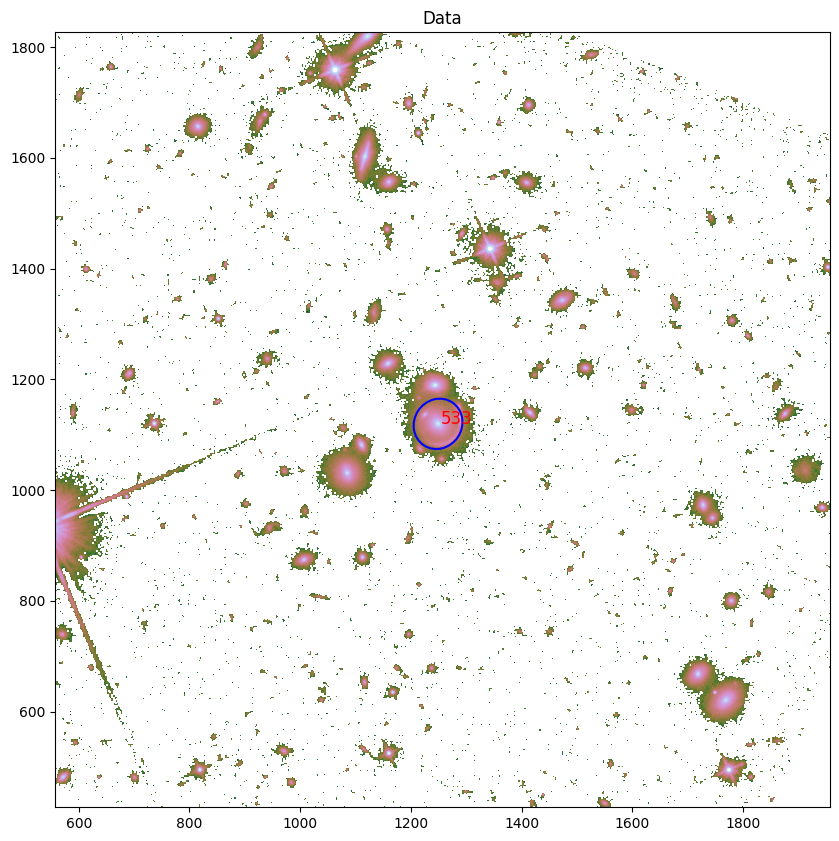

In [16]:
# object id of your central deflector/lens
id_central = 533

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
    # transform=ax1.transAxes
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [17]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating Lists of neighbouring Galaxies

In [18]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08:  # radius: 30 arcseconds
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of All Close galaxies within 30 arcseconds radius:", len(close_galaxies_all)
)

Number of All Close galaxies within 30 arcseconds radius: 107


In [19]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 50 / 0.08) & (
        f > f0 * 0.01
    ):  # radius: 30 arcseconds
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of Close galaxies (excluding the dim sources) within 50 arcseconds radius: ",
    len(close_galaxies_1),
)

Number of Close galaxies (excluding the dim sources) within 50 arcseconds radius:  53


## Pixels to Megaparsec unit

In [20]:
def distance_parsec(pixel_distance, z):
    """Convert distance from unit of pixels into parsec unit.

    :param pixel_distance: distance in unit of pixels
    
    :param z: photometric redshift

    :return: distance in parsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert the pixel scale from degrees to radians
    pix_scale_radian = pix_scale_deg * np.pi / 180
    
    # Angles in radians
    angles_radian = pixel_distance * pix_scale_radian
    
    # Define cosmological parameters
    H0 = 70   # Hubble constant in km/s/Mpc
    Om0 = 0.3 # Matter density parameter
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    
    # Compute the angular diameter distance
    angular_diameter_distance = cosmo.angular_diameter_distance(z)
    
    # Calculate the physical distance
    physical_distances_mpc = angular_diameter_distance * angles_radian 

    return physical_distances_mpc

In [21]:
id_central_2drop = [531, 532, 533, 534, 535]  # parts of the central deflector and lensed arc
id_others_2drop = [556, 557, 558, 559, 364, 370, 349, 538, 248, 317, 212, 282]  # stars with diffraction spikes

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

# Photometric redshift of the deflector galaxy is 0.4
df_all["Distance(megaparsec)"] = distance_parsec(df_all["Distance(pixels)"], 0.4)
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# drop the central and other unwanted ids
df_all = df_all.drop(index=id_central_2drop)
df_all = df_all.drop(index=id_others_2drop)

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")
df_all_sys_removed = df_all_sorted

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20.shape)
print(df_all_20)

(20, 4)
     Distance(pixels)  Distance(megaparsec)         Flux  Axis Ratio
536         47.300587              0.020331   180.215017    0.538703
222         55.651402              0.023921   105.115521    0.731898
537         58.509476              0.025149   134.091058    0.806253
247         59.854971              0.025728    31.819587    0.775828
218         64.335221              0.027654    64.207202    0.859296
255         73.969651              0.031795    13.487342    0.874844
264         91.847574              0.039479    11.345277    0.525774
235         96.486799              0.041473     4.990751    0.705338
278        100.438572              0.043172     6.899752    0.808634
530        131.148855              0.056372    21.253839    0.585016
286        131.586119              0.056560    19.389994    0.645430
245        139.030057              0.059760     6.493701    0.781581
273        141.284376              0.060729   837.500953    0.736725
529        143.696775     

In [22]:
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

# Photometric redshift of the deflector galaxy is 0.4
df_1["Distance(megaparsec)"] = distance_parsec(df_1["Distance(pixels)"], 0.4)
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system and other undesirable members
df_1_sys_removed = df_1_sorted.drop(
    index=id_central_2drop + [556, 557, 538, 248, 317, 212, 282, 518, 305, 254, 366, 339, 395, 95, 89, 106, 523, 230]
)  # 558 and 559 are the non-central star ids (excluding the dim sources)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20.shape)
print(df_1_20)

(20, 4)
     Distance(pixels)  Distance(megaparsec)         Flux  Axis Ratio
536         47.300587              0.020331   180.215017    0.538703
222         55.651402              0.023921   105.115521    0.731898
537         58.509476              0.025149   134.091058    0.806253
218         64.335221              0.027654    64.207202    0.859296
273        141.284376              0.060729   837.500953    0.736725
529        143.696775              0.061766   520.664536    0.630337
239        167.011435              0.071787   366.410982    0.567190
224        174.694453              0.075090    35.852245    0.936974
203        186.837988              0.080309  1829.472321    0.856666
550        231.971104              0.099709   112.867643    0.612392
166        277.375434              0.119226   209.445351    0.884503
330        277.594031              0.119320   156.714160    0.827717
274        284.647698              0.122351   209.136062    0.815130
163        345.064974     

## Determining $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ and the corresponding radii

/tmp/ipykernel_18/257438462.py:17: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/257438462.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/257438462.py:20: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/257438462.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/257438462.py:23: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/257438462.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap=

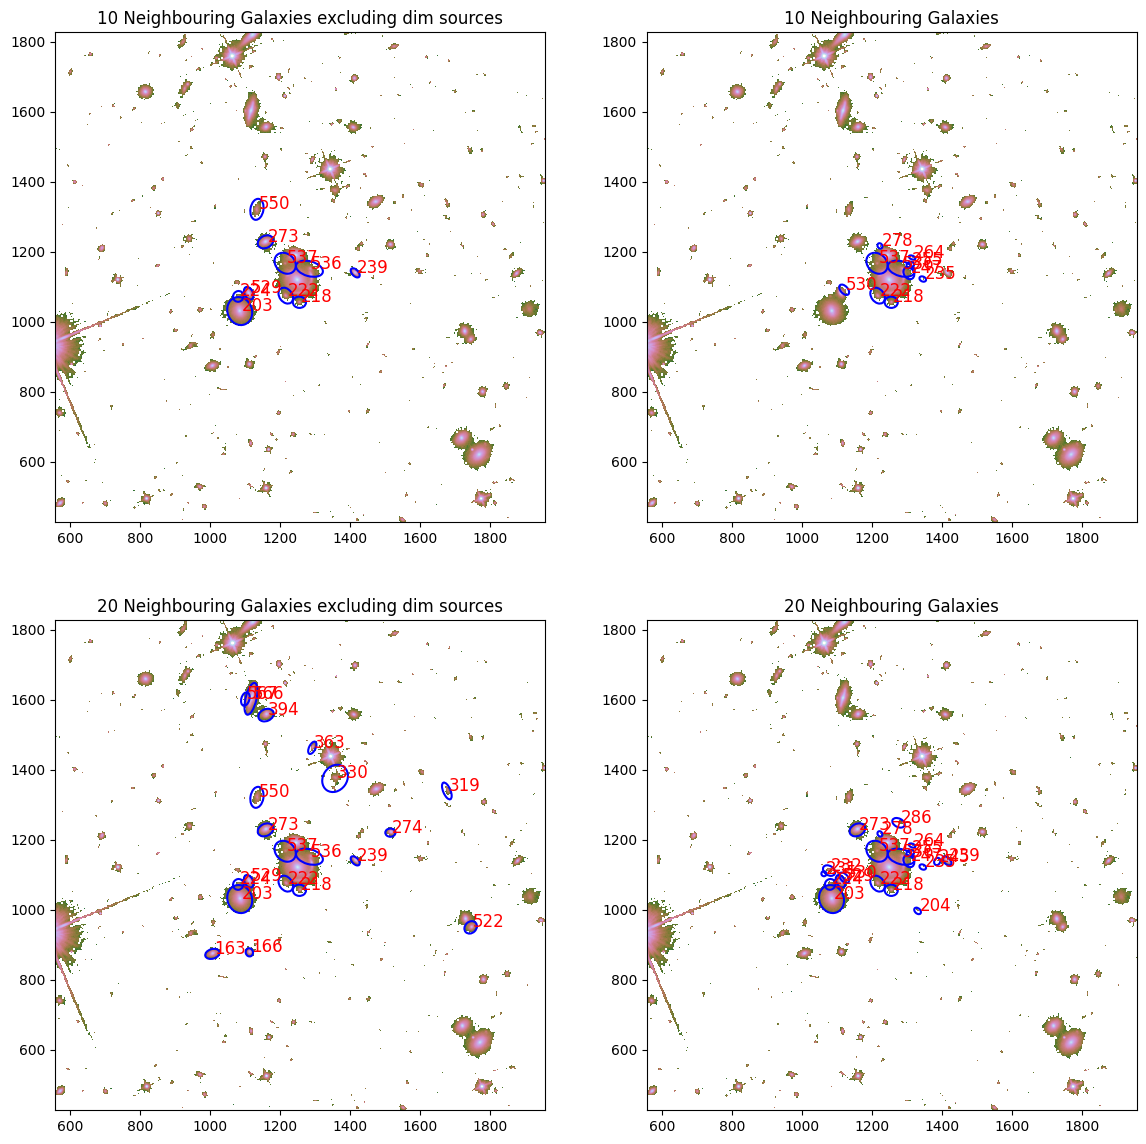

In [23]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

## Loading Global Mean

In [24]:
# Read flux data from each YAML file and append to corresponding lists
input_path = f"/kaggle/input/global-means-updated/DESIJ1018-0121_means.yml"

try:
    with open(input_path, "r") as f:
        data_mean = yaml.safe_load(f)
except (AttributeError, yaml.YAMLError) as e:
    print(f"Failed to load {lens_name}: {e}")
    
global_mean_flux_10 = data_mean.get("Global_mean_flux_10")
global_mean_flux_20 = data_mean.get("Global_mean_flux_20")
global_mean_flux_selected_10 = data_mean.get("Global_mean_flux_selected_10")
global_mean_flux_selected_20 = data_mean.get("Global_mean_flux_selected_20")
global_mean_flux_dis_10 = data_mean.get("Global_mean_flux_dis_10")
global_mean_flux_dis_20 = data_mean.get("Global_mean_flux_dis_20")
global_mean_flux_dis_selected_10 = data_mean.get("Global_mean_flux_dis_selected_10")
global_mean_flux_dis_selected_20 = data_mean.get("Global_mean_flux_dis_selected_20")

## Method A

In [25]:
# For all sources
R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(megaparsec)")]
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(megaparsec)")]
Sigma_10_allA = 10 / (np.pi * R_10_all**2)
Sigma_20_allA = 20 / (np.pi * R_20_all**2)

# Excluding dim sources
R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(megaparsec)")]
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(megaparsec)")]
Sigma_10_1A = 10 / (np.pi * R_10_1**2)
Sigma_20_1A = 20 / (np.pi * R_20_1**2)


print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_allA)
print("Sigma 20:", Sigma_20_allA)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1A)
print("Sigma 20:", Sigma_20_1A)


FOR All SOURCES
R 10: 0.056372336130660526
R 20: 0.08030946096692447
Sigma 10: 1001.6547656726041
Sigma 20: 987.0671554838826

EXCLUDING DIM SOURCES
R 10: 0.09970924295894917
R 20: 0.22524798133937352
Sigma 10: 320.1690073502537
Sigma 20: 125.47531882811904


## Method B

In [26]:
weighted_flux_10_all = np.sum(df_all_20["Flux"][0:10] / global_mean_flux_10)
weighted_flux_20_all = np.sum(df_all_20["Flux"][0:20] / global_mean_flux_20)
Sigma_10_allB = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allB = weighted_flux_20_all / (np.pi * R_20_all**2)


weighted_flux_10_1 = np.sum(df_1_20["Flux"][0:10] / global_mean_flux_selected_10)
weighted_flux_20_1 = np.sum(df_1_20["Flux"][0:20] / global_mean_flux_selected_20)
Sigma_10_1B = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1B = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allB)
print("Sigma 20_updated:", Sigma_20_allB)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1B)
print("Sigma 20_updated:", Sigma_20_1B)


Considering Light Flux
FOR All SOURCES
R 10: 0.056372336130660526
R 20: 0.08030946096692447
Sigma 10_updated: 808.1571769767911
Sigma 20_updated: 3183.1679174101555

EXCLUDING DIM SOURCES
R 10: 0.09970924295894917
R 20: 0.22524798133937352
Sigma 10_updated: 626.7008867897995
Sigma 20_updated: 277.97927595197746


## Method C

In [27]:
flux_c_10_all = []
flux_c_20_all = []
flux_c_10_1 = []
flux_c_20_1 = []

# for all sources
for i in range(20):
    flux_all = df_all_20["Flux"][i:i+1] / df_all_20["Distance(megaparsec)"][i:i+1]
    
    if i < 10:
        flux_c_10_all.append(flux_all)
        flux_c_20_all.append(flux_all)
        
    elif 9 < i < 20:
        flux_c_20_all.append(flux_all)
        
weighted_flux_10_all = np.sum(flux_c_10_all) / global_mean_flux_dis_10
weighted_flux_20_all = np.sum(flux_c_20_all) / global_mean_flux_dis_20
Sigma_10_allC = weighted_flux_10_all  / (np.pi * R_10_all**2)
Sigma_20_allC = weighted_flux_20_all / (np.pi * R_20_all**2)

# excluding dim sources
for i in range(20):
    flux_1 = df_1_20["Flux"][i:i+1] / df_1_20["Distance(megaparsec)"][i:i+1]
    
    if i < 10:
        flux_c_10_1.append(flux_1)
        flux_c_20_1.append(flux_1)
        
    elif 9 < i < 20:
        flux_c_20_1.append(flux_1)
        
weighted_flux_10_1 = np.sum(flux_c_10_1) / global_mean_flux_dis_selected_10
weighted_flux_20_1 = np.sum(flux_c_20_1) / global_mean_flux_dis_selected_10
Sigma_10_1C = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1C = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allC)
print("Sigma 20_updated:", Sigma_20_allC)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1C)
print("Sigma 20_updated:", Sigma_20_1C)


Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.056372336130660526
R 20: 0.08030946096692447
Sigma 10_updated: 2207.6487112279774
Sigma 20_updated: 4160.040941713485

EXCLUDING DIM SOURCES
R 10: 0.09970924295894917
R 20: 0.22524798133937352
Sigma 10_updated: 1039.3485949540332
Sigma 20_updated: 260.8016128033382


## Method D

In [28]:
# Initialize flux variables
flux_d_10_all = []
flux_d_20_all = []
flux_d_10_1 = []
flux_d_20_1 = []

# Define a short radius
pixel_distance = 125 # for 10 arcseconds

# Mean Photometric redshift of all the deflectors is 0.581
s = distance_parsec(pixel_distance, 0.581).value

# Process both dataframes
for i in range(20):
    distance_all = df_all_20["Distance(megaparsec)"].iloc[i]
    flux_all = df_all_20["Flux"].iloc[i]
    distance_1 = df_1_20["Distance(megaparsec)"].iloc[i]
    flux_1 = df_1_20["Flux"].iloc[i]
    
    # Processing for df_all_20
    if i < 10:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_d_10_all.append(flux_contrib_all)
        flux_d_20_all.append(flux_contrib_all)
        
    elif 9 < i < 20:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_d_20_all.append(flux_contrib_all)
    
    # Processing for df_1_20
    if i < 10:
        
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_d_10_1.append(flux_contrib_1)
        flux_d_20_1.append(flux_contrib_1)
        
    elif 9 < i < 20:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_d_20_1.append(flux_contrib_1)

weighted_flux_10_all = np.sum(flux_d_10_all) / global_mean_flux_dis_10
weighted_flux_20_all = np.sum(flux_d_20_all) / global_mean_flux_dis_20
Sigma_10_allD = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allD = weighted_flux_20_all / (np.pi * R_20_all**2)

weighted_flux_10_1 = np.sum(flux_d_10_1) / global_mean_flux_dis_selected_10
weighted_flux_20_1 = np.sum(flux_d_20_1) / global_mean_flux_dis_selected_20
Sigma_10_1D = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1D = weighted_flux_20_1 / (np.pi * R_20_1**2)

# Print results
print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allD)
print("Sigma 20_updated:", Sigma_20_allD)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1D)
print("Sigma 20_updated:", Sigma_20_1D)


Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.056372336130660526
R 20: 0.08030946096692447
Sigma 10_updated: 817.4362327576778
Sigma 20_updated: 3248.1744820773265

EXCLUDING DIM SOURCES
R 10: 0.09970924295894917
R 20: 0.22524798133937352
Sigma 10_updated: 822.3472414710063
Sigma 20_updated: 326.4576371525144


## Store the $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ values in the YAML file

In [29]:
import shutil
src_path = r"/kaggle/input/point-estimates/DESIJ1018-0121_point_estimates.yml"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)

# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1018-0121_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10a_flux_selected": Sigma_10_1A,
    "Sigma_20a_flux_selected": Sigma_20_1A,
    "Sigma_10a": Sigma_10_allA,
    "Sigma_20a": Sigma_20_allA,
    
    "Sigma_10b_flux_selected": Sigma_10_1B,
    "Sigma_20b_flux_selected": Sigma_20_1B,
    "Sigma_10b": Sigma_10_allB,
    "Sigma_20b": Sigma_20_allB,
    
    "Sigma_10c_flux_selected": Sigma_10_1C,
    "Sigma_20c_flux_selected": Sigma_20_1C,
    "Sigma_10c": Sigma_10_allC,
    "Sigma_20c": Sigma_20_allC,
    
    "Sigma_10d_flux_selected": Sigma_10_1D,
    "Sigma_20d_flux_selected": Sigma_20_1D,
    "Sigma_10d": Sigma_10_allD,
    "Sigma_20d": Sigma_20_allD
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [30]:
# convert the numpy.float64 values to floats

Sigma_10_1A = Sigma_10_1A.item()
Sigma_20_1A = Sigma_20_1A.item()
Sigma_10_allA = Sigma_10_allA.item()
Sigma_20_allA = Sigma_20_allA.item()

Sigma_10_1B = Sigma_10_1B.item()
Sigma_20_1B = Sigma_20_1B.item()
Sigma_10_allB = Sigma_10_allB.item()
Sigma_20_allB = Sigma_20_allB.item()

Sigma_10_1C = Sigma_10_1C.item()
Sigma_20_1C = Sigma_20_1C.item()
Sigma_10_allC = Sigma_10_allC.item()
Sigma_20_allC = Sigma_20_allC.item()

Sigma_10_1D = Sigma_10_1D.item()
Sigma_20_1D = Sigma_20_1D.item()
Sigma_10_allD = Sigma_10_allD.item()
Sigma_20_allD = Sigma_20_allD.item()

In [31]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1018-0121_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10a_flux_selected": Sigma_10_1A,
    "Sigma_20a_flux_selected": Sigma_20_1A,
    "Sigma_10a": Sigma_10_allA,
    "Sigma_20a": Sigma_20_allA,
    
    "Sigma_10b_flux_selected": Sigma_10_1B,
    "Sigma_20b_flux_selected": Sigma_20_1B,
    "Sigma_10b": Sigma_10_allB,
    "Sigma_20b": Sigma_20_allB,
    
    "Sigma_10c_flux_selected": Sigma_10_1C,
    "Sigma_20c_flux_selected": Sigma_20_1C,
    "Sigma_10c": Sigma_10_allC,
    "Sigma_20c": Sigma_20_allC,
    
    "Sigma_10d_flux_selected": Sigma_10_1D,
    "Sigma_20d_flux_selected": Sigma_20_1D,
    "Sigma_10d": Sigma_10_allD,
    "Sigma_20d": Sigma_20_allD
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

## Determining the mean for normalizing

In [32]:
#Mean of Fluxes
flux_10_mean = np.mean(df_all_20["Flux"][0:10])
flux_20_mean = np.mean(df_all_20["Flux"][0:20])
flux_10_1_mean = np.mean(df_1_20["Flux"][0:10])
flux_20_1_mean = np.mean(df_1_20["Flux"][0:20])

#Mean of Flux/Distance
flux_d_10_mean = np.mean(flux_d_10_all)
flux_d_20_mean = np.mean(flux_d_20_all)
flux_d_10_1_mean = np.mean(flux_d_10_1)
flux_d_20_1_mean = np.mean(flux_d_20_1)

print(flux_10_mean, flux_20_mean, flux_10_1_mean, flux_20_1_mean)
print(flux_d_10_mean, flux_d_20_mean, flux_d_10_1_mean, flux_d_20_1_mean)

57.342534689351055 211.54444469792685 418.6397478269885 393.24317470331175
870.7865000165268 2932.92489799365 5746.276325002482 3891.9374771622147


In [33]:
mean_variables = {
    "Flux_10b_mean": flux_10_mean,
    "Flux_20b_mean": flux_20_mean,
    "Flux_selected_10b_mean": flux_10_1_mean,
    "Flux_selected_20b_mean": flux_20_1_mean,
    
    "Flux_dis_10_mean": flux_d_10_mean,
    "Flux_dis_20_mean": flux_d_20_mean,
    "Flux_dis_10_1_mean": flux_d_10_1_mean,
    "Flux_dis_20_1_mean": flux_d_20_1_mean
}

# make all the numpy variales to float
mean_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in mean_variables.items()
}

In [34]:
# Write the dictionary to a YAML file
yaml_file_name = "DESIJ1018-0121_means.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(mean_variables, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

YAML file 'DESIJ1018-0121_means.yml' created successfully.
